* Student name: Matan Gavish
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: San-Pietro > Brandon Lewis > Eli Thomas
* Blog post URL:


# Introduction

Our planet looses 48 football fields worth of forests every minute, and most of that loss is in the Amazon Basin where the earth suffers reduced biodiversity, habitat loss and contribution to climate change.  With better data and insight about locations of deforestation and human encroachment, we can help governments and stakeholders to respond with greater efficacy.  

This notebook explores satellite imagery data collected by [Planet](https://www.planet.com/company/careers/) who's goal it is to develop algorithms to understand how and why deforestation happens all over the world and ultimately, how to respond.  
The goal here is to train a model that can tag Amazon Rain Forest images using seventeen possible labels concerning atmospheric conditions and different classes of land cover and land use.  

# Getting acquainted with our data

The [Kaggle Competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) was provided with roughly 40,000 multi-label images for classification using seventeen possible labels.   

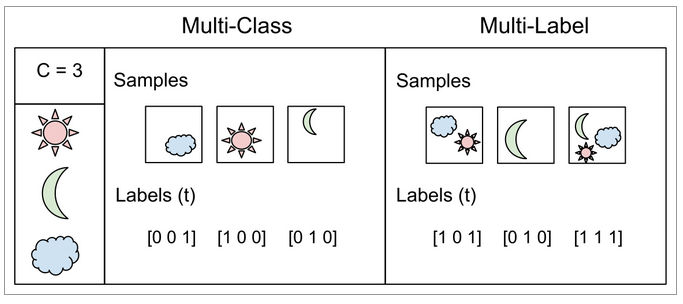
[source](https://miro.medium.com/max/683/1*3urmp9yuK1Ys39UO5j41kg.png)

In [2]:
# load dependancies

import os, sys

import pandas as pd
pd.options.display.max_rows

import numpy as np
from numpy import ones
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from numpy import load

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import fbeta_score


from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras import backend
from keras.optimizers import SGD

import cv2

Using TensorFlow backend.


In [3]:
# view file info

print('# File sizes')
for f in os.listdir('input/'):
    if not os.path.isdir('input/' + f):
        print(f.ljust(30) + str(round(os.path.getsize('input/' + f) / 1000000, 2)) + 'MB') #.ljust returns the string left 
    else:                                                                                                        #justified
        sizes = [os.path.getsize('input/'+f+'/'+x)/1000000 for x in os.listdir('input/' + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
train-jpg                     13.89MB (1 files)
train-jpg.tar                 665.75MB
train-jpg.tar.7z              629.3MB
train-tif-v2.tar              21264.11MB
train-tif-v2.tar.7z           13815.6MB
train_v2.csv                  1.43MB
train_v2.csv.zip              0.16MB


In [4]:
# use pandas to import, read, inspect and manipulation data in the provided train.csv file

labels_df = pd.read_csv('input/train_v2.csv')
print()
print(f'there are {len(labels_df)} images in the dataset')
print()
labels_df.head()


there are 40479 images in the dataset



,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


The provided train_v2 csv file provides us with photo image identifiers and their associated space-delimited tags.  
Below, we will write a function that returns a list of unique labels which we will use later to get dummies/indicator variables.

In [15]:
# Build list with unique labels

label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
            
print(f'There are {len(label_list)} labels in the data set')

There are 17 labels in the data set


In [6]:
# Add onehot features for every label

for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [6]:
# use the unique list of one-hot-encoded tags to review the unique labels and thier frequency

labels_df[label_list].sum().sort_values()

blow_down               98
conventional_mine      100
slash_burn             209
blooming               332
artisinal_mine         339
selective_logging      340
bare_ground            862
cloudy                2089
haze                  2697
habitation            3660
cultivation           4477
partly_cloudy         7261
water                 7411
road                  8071
agriculture          12315
clear                28431
primary              37513
dtype: int64

We can see large class imbalances are present; lets get through a baseline model and review performance before we think about what to do here, if anything.

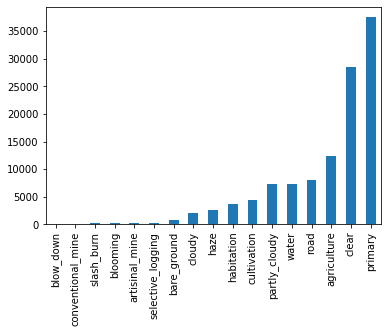

In [7]:
# Histogram of label instances

labels_df[label_list].sum().sort_values().plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


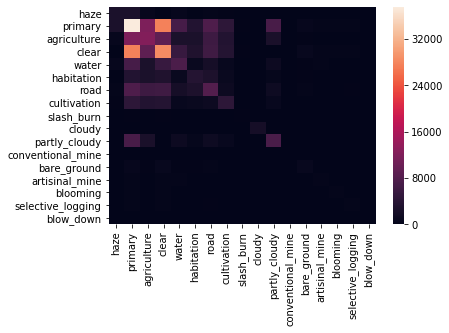

In [16]:
# we can look at how often pairs of features occur together

def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

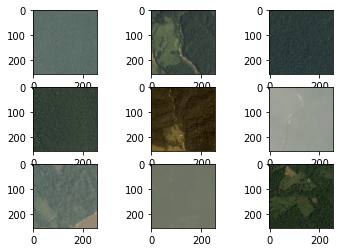

In [9]:
# look at the first 9 images in the planet dataset

# define location of dataset
folder = 'input/train-jpg/train-jpg/'
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'train_' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.figsize = (10,10)
    
    plt.imshow(image)
# show the figure
plt.show()

##### Observations
The data consists of roughly 40,000 rgb photos with 17 possible tags.
There are large class imbalances and the co-occurance matrix shows that 'primary', 'agriculture' and 'clear' often appear together. 

# Prepare the image data for ML

The data structure of the input to our classification model will look like any other input to a neural network; we will convert the images into tensors which are essentially higher functioning matrices since the tensor can keep the photo id associated with the image data.  The difference here is that we are dealing with a multi-label classification problem (any one image can contain multiple targets) rather than a multi-class classification where an image could be only one of a given number of classes.  

In multi-label classification problems, we must convert each observations target into a one-hot encoded vector containing each possible feature. 

The large majority of code here was origianlly found on [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/)

In [10]:
# create a mapping of unique tags to integers using the train_v2.csv to use when we one-hot encode; this is essentialy equal
# ...to getting dummies

def create_tag_mapping(mapping_csv):
    # Initialize a set to place all unique tags
    unique_tags = set()
    for i in range(len(mapping_csv)):
        # convert space separated tags into an array of tags
        tags = mapping_csv['tags'][i].split(' ')
        # add tags to the set of known labels
        unique_tags.update(tags)
    # convert set of tags to a list so we can sort
    unique_tags = list(unique_tags)
    # order set alphabetically
    unique_tags.sort()
    # dict that maps labels to integers, and the reverse
    labels_map = {unique_tags[i]:i for i in range(len(unique_tags))}
    inv_labels_map = {i:unique_tags[i] for i in range(len(unique_tags))}
    return labels_map, inv_labels_map
 

In [20]:
# sanity check
create_tag_mapping(pd.read_csv('input/train_v2.csv'))

({'agriculture': 0,
  'artisinal_mine': 1,
  'bare_ground': 2,
  'blooming': 3,
  'blow_down': 4,
  'clear': 5,
  'cloudy': 6,
  'conventional_mine': 7,
  'cultivation': 8,
  'habitation': 9,
  'haze': 10,
  'partly_cloudy': 11,
  'primary': 12,
  'road': 13,
  'selective_logging': 14,
  'slash_burn': 15,
  'water': 16},
 {0: 'agriculture',
  1: 'artisinal_mine',
  2: 'bare_ground',
  3: 'blooming',
  4: 'blow_down',
  5: 'clear',
  6: 'cloudy',
  7: 'conventional_mine',
  8: 'cultivation',
  9: 'habitation',
  10: 'haze',
  11: 'partly_cloudy',
  12: 'primary',
  13: 'road',
  14: 'selective_logging',
  15: 'slash_burn',
  16: 'water'})

In [22]:
# create a mapping of filenames to a list of their respective tags

def create_file_mapping(mapping_csv):
    mapping = dict()
    for i in range(len(mapping_csv)):
        name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
        mapping[name] = tags.split(' ')
    return mapping


In [23]:
# sanity check
create_file_mapping(pd.read_csv('input/train_v2.csv'))

{'train_0': ['haze', 'primary'],
 'train_1': ['agriculture', 'clear', 'primary', 'water'],
 'train_2': ['clear', 'primary'],
 'train_3': ['clear', 'primary'],
 'train_4': ['agriculture', 'clear', 'habitation', 'primary', 'road'],
 'train_5': ['haze', 'primary', 'water'],
 'train_6': ['agriculture', 'clear', 'cultivation', 'primary', 'water'],
 'train_7': ['haze', 'primary'],
 'train_8': ['agriculture', 'clear', 'cultivation', 'primary'],
 'train_9': ['agriculture', 'clear', 'cultivation', 'primary', 'road'],
 'train_10': ['agriculture', 'clear', 'primary', 'slash_burn', 'water'],
 'train_11': ['clear', 'primary', 'water'],
 'train_12': ['cloudy'],
 'train_13': ['clear', 'primary'],
 'train_14': ['cloudy'],
 'train_15': ['clear', 'primary'],
 'train_16': ['clear', 'primary'],
 'train_17': ['partly_cloudy', 'primary'],
 'train_18': ['clear', 'primary'],
 'train_19': ['agriculture', 'clear', 'primary', 'road'],
 'train_20': ['agriculture', 'clear', 'primary', 'water'],
 'train_21': ['clea

In [ ]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    # create empty vector
    encoding = zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding
 


In [ ]:
# loads all images into memory

def load_dataset(path, file_mapping, tag_mapping):
    photos, targets = list(), list()
    # enumerate files in the directory
    for filename in os.listdir(folder):
        # load image
        photo = load_img(path + filename, target_size=(128,128))
        # convert to numpy array
        photo = img_to_array(photo, dtype='uint8')
        # get tags
        tags = file_mapping[filename[:-4]]
        # one hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # store
        photos.append(photo)
        targets.append(target)
    X = asarray(photos, dtype='uint8')
    y = asarray(targets, dtype='uint8')
    return X, y
 

In [ ]:
# save the machine readable array of data using NumPy's savez_compressed

filename = 'input/train_v2.csv'
mapping_csv = pd.read_csv(filename)
# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(mapping_csv)
# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(mapping_csv)
# load the jpeg images
folder = 'input/train-jpg/train-jpg/'
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)
# save both arrays to one file in compressed format
savez_compressed('planet_data.npz', X, y)

we now have all of the data (inputs and outputs) in a saved file that is machine readable

# Train a Baseline Model

Before training a baseline model, we need to create a function to load our new npz data file into memory, and also an evaluation metric.

##### Evaluation Metric

classification accuracy is appropriate for binary classification with a balanced number of examples in each class.  Here, we are working with multi-label classification (as apposed to multi-class classification) where labels are imbalanced.

The competition is using the F2-score (related to the F1 score; which is a weighted average of Precision and Recall.  
The F1 takes the average of precision and recall while the F2 introduces a term called *beta* that weights how important recall is compared to precision, within its calculation for mean.

[fbeta score from kaggle](https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras)  
[fbeta score for keras](https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras)

In [ ]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score


In [ ]:
# function to load the saved npz data set into memory
def load_dataset():
    # load dataset
    data = load('planet_data.npz')
    X, y = data['arr_0'], data['arr_1']
    # separate into train and test datasets
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY


# define the baseline cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model


# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Fbeta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='test')
    
    
    
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

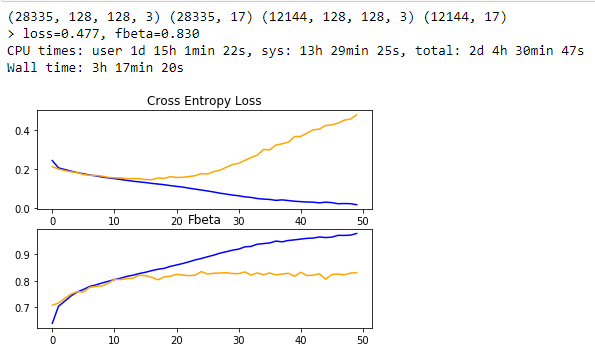

Our baseline model took 3 hours and 17 min using a CPU, and got an fbeta of 0.830.  
We can see that the test set hangs with the training data until somewhere close to 15 epochs, and then loss gets worse and the training data begins to over-fit.  

Next, we can look at the use of dropout regularization and image data augmentation to address the over-fitting.

# Baseline + Dropout Regularization

In [ ]:
# baseline cnn with dropout regularization

def define_model(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

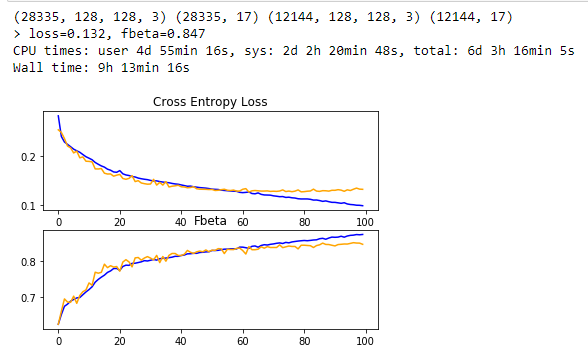

100 epochs took 9 hours and 13 minutes on CPU and got an fbeta of 0.847. 
Here we can see that dropout regularization avoided over fitting much longer and doesn't begin until 60 epochs.

running time using a GPU was incredibly faster!:

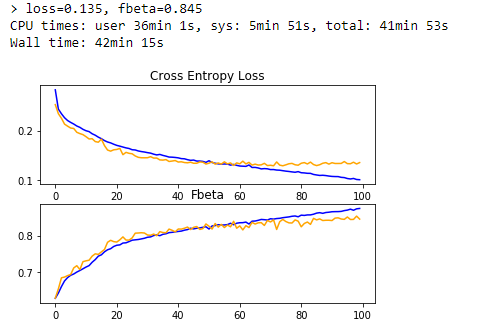




Image Data Augmentation can be used to artificially expand data on small data sets and can also act as a Regularization technique that introduces noise to the training set and encourages the model to learn those augmented features.  We will introduce horizontal flips, vertical flips, rotations and zooms.

# Baseline + Image Data Augmentation

In [ ]:
# run the test harness for evaluating a model
# we augment data in the training set only 
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size=128)
    test_it = test_datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history)


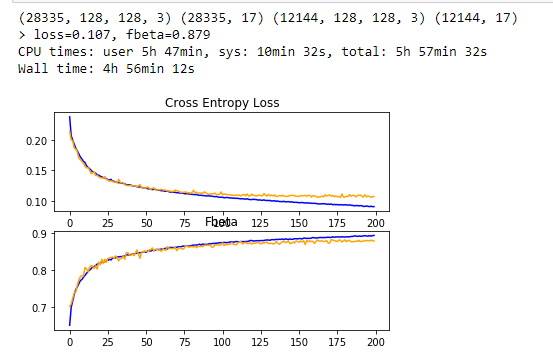

# Transfer Learning

We use the vgg16 pre-trained network.  The vgg16 convolutional network achieved a top-5 test score of 92.7% on the ImageNet data set, which is comprised of over 15 million images belonging to 1,000 classes.  We will use all the learned weights from the vgg16 model and then run it again after allowing the deepest layers to train on the new data from the Amazon data set.  

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [ ]:
# vgg16 transfer learning on the planet dataset

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    datagen = ImageDataGenerator(featurewise_center=True) #InageNet expects images to be centered
    # specify imagenet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939] #rgb input shape less mean from ImageNet
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history)

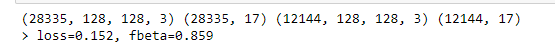



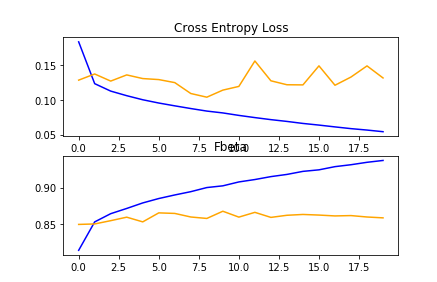

|model                             | # Epochs | wall time |CPU or GPU | fBeta |
|:---------------------:           |:--------:|:---------:| :-------: | :----:|
|Baseline                          |    50    | 3h 17min  | CPU       | 0.830 |
|Baseline + Dropout Regularization |    100   | 9h 13min  | CPU       | 0.847 |
|Baseline + Dropout Regularization |    100   | 0h 36min  | GPU p100  | 0.845 |
|Baseline + Image Data Augmentation|    200   | 4h 56min  | GPU p100  | 0.879 |
|Transfer Learning                 |    20    | 7h 22min  | GPU v100  | 0.861 |
|Transfer Learning+Fine Tuning     |    20    | h min  | GPU v100  | 0.000 |
|Transfer Learning+Fine Tuning+<br>Image Data Augmentation| 30 | 14hr 48min  |GPU V100 |0.894|
|Transfer Learning+Fine Tuning+<br>Image Data Augmentation+<br>Early Stopping|12| 7hr 37min | GPU v100 |0.896| 
|Transfer Learning+Fine Tuning+<br>Image Data Augmentation+<br>Adam Optimizer| 30 | 0hr 43min  |GPU V100 |0.883|

|  |model                             | # Epochs | wall time |CPU or GPU | fBeta |
|:--:|:---------------------:           |:--------:|:---------:| :-------: | :----:|
|1|Baseline                          |    50    | 3h 17min  | CPU       | 0.830 |
|2|Baseline + Dropout Regularization |    100   | 9h 13min  | CPU       | 0.847 |
|3|Baseline + Dropout Regularization |    100   | 0h 36min  | GPU p100  | 0.845 |
|4|Baseline + Image Data Augmentation|    200   | 4h 56min  | GPU p100  | 0.879 |
|5|Transfer Learning                 |    20    | 7h 22min  | GPU v100  | 0.861 |
|6|Transfer Learning+Fine Tuning     |    20    | h min  | GPU v100  | 0.000 |
|7|Transfer Learning+Fine Tuning+<br>Image Data Augmentation| 30 | 14hr 48min  |GPU V100 |0.894|
|8|Transfer Learning+Fine Tuning+<br>Image Data Augmentation+<br>Early Stopping|12| 7hr 37min | GPU v100 |0.896| 
|9|Transfer Learning+Fine Tuning+<br>Image Data Augmentation+<br>Adam Optimizer| 30 | 0hr 43min  |GPU V100 |0.883|
